# Executive Summary: Soccer Analytics EDA

## Georgia Tech MSA Spring 2026 Practicum

---

## 1. Executive Summary

This analysis evaluates whether event-level match data from the StatsBomb dataset can meaningfully explain match outcomes and how these signals relate to Polymarket prediction market pricing.

### Key Findings

**Shot quality is the strongest predictor of match outcome.** Expected goal differential (`xg_diff`) alone explains nearly half (R² = 0.475) of the variation in actual goal differential across 3,464 matches spanning La Liga, Premier League, Serie A, Ligue 1, and other major competitions.

**Pass completion rate is highly uniform across the dataset.** The overall success rate of 77.7% is consistent across competitions, suggesting that raw pass volume alone is not a strong differentiator — but contextual passing metrics (e.g., final-third entries) may prove more informative.

**Polymarket activity is concentrated in a small number of high-profile competitions.** Champions League Winner markets account for over $1B of the $3B+ total trading volume across 8,549 markets. This concentration suggests that market efficiency analysis should focus on these liquid markets rather than long-tail events.

**Entity resolution between StatsBomb and Polymarket is feasible but incomplete.** We successfully mapped 150+ teams across datasets. Major clubs have strong coverage, but smaller clubs and non-European teams have limited or no betting market presence.

### Implications

- Event-level dominance metrics (xG, pressure, field tilt) can serve as a meaningful baseline for estimating pre-match expected outcomes.
- The concentration of market volume in top-tier competitions makes those competitions the best candidates for any market efficiency analysis.
- Dashboard-based exploration of team styles and match dynamics can surface non-trivial insights that static reports cannot.

---

## Track Selection: Track 2 — Soccer Analytics Dashboard

Based on our EDA findings, we will focus on building an interactive dashboard that showcases:
- xG flow visualizations for individual matches
- Team style comparisons (possession-based vs. high-pressing vs. counter-attacking)
- Player performance analytics (xG leaders, pass networks)
- Competition-level scoring and tactical metrics (PPDA, Field Tilt)

This choice is motivated by:
1. The richness of StatsBomb event data, which enables compelling and reproducible visualizations across matches and seasons.
2. Our feature engineering pipeline already computes advanced metrics (PPDA, Field Tilt, Expected Threat) that benefit from interactive exploration.
3. A dashboard can serve both technical and non-technical audiences, making insights accessible and actionable.

---

*Full technical analysis and supporting work: see [`EDA.ipynb`](EDA.ipynb)*

In [1]:
# Setup
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import polars as pl

warnings.filterwarnings('ignore')
plt.style.use('dark_background')

COLORS = {'primary': '#F49D52', 'secondary': '#759ACE', 'success': '#10b981', 'background': '#1A1B3A'}

DATA_DIR = Path('../data')
sb_matches = pl.read_parquet(DATA_DIR / 'Statsbomb/matches.parquet')
sb_events = pl.read_parquet(DATA_DIR / 'Statsbomb/events.parquet')
pm_markets = pl.read_parquet(DATA_DIR / 'Polymarket/soccer_markets.parquet')

print(f'✓ Loaded {len(sb_matches):,} matches, {len(sb_events):,} events, {len(pm_markets):,} markets')

✓ Loaded 3,464 matches, 12,188,949 events, 8,549 markets


## Highlight 1: Competition Coverage

The data covers major competitions with strong representation from top European leagues.

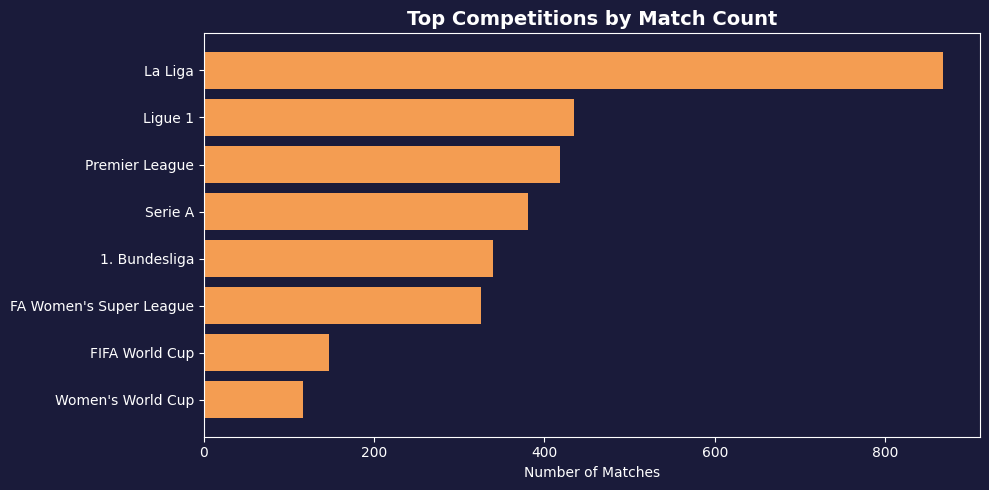

La Liga leads with 868 matches, followed by Ligue 1 and Premier League.


In [2]:
# Competition distribution
comp_dist = sb_matches.group_by('competition_name').agg([
    pl.len().alias('matches'),
    (pl.col('home_score') + pl.col('away_score')).mean().alias('avg_goals')
]).sort('matches', descending=True).head(8)

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(comp_dist['competition_name'].to_list()[::-1], comp_dist['matches'].to_list()[::-1],
        color=COLORS['primary'], edgecolor='none')
ax.set_xlabel('Number of Matches')
ax.set_title('Top Competitions by Match Count', fontweight='bold', fontsize=14)
ax.set_facecolor(COLORS['background'])
fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

print(f"La Liga leads with {comp_dist['matches'][0]} matches, followed by Ligue 1 and Premier League.")

## Highlight 2: xG Distribution & Top Scorers

Expected Goals (xG) analysis reveals shot quality patterns and identifies elite finishers.

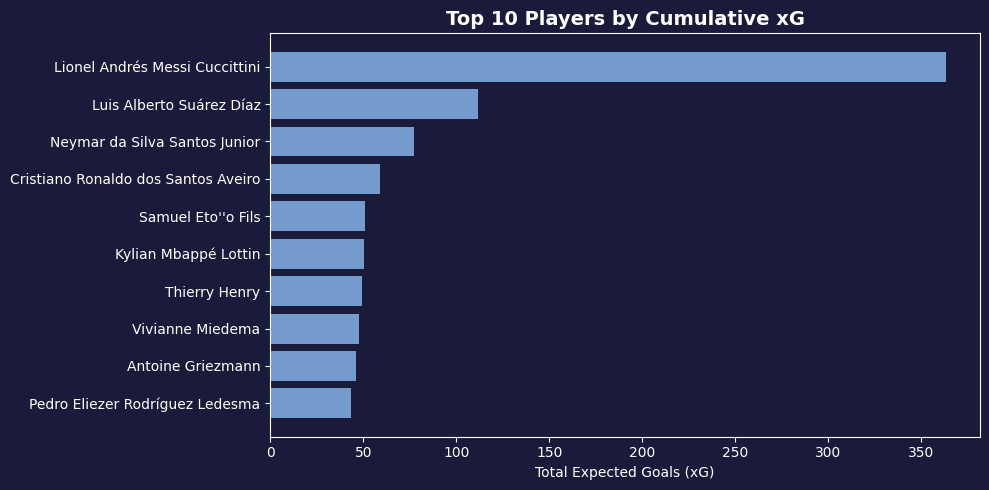

Messi leads with 363.4 xG from 2670 shots.


In [3]:
# xG analysis
shots = sb_events.filter((pl.col('type') == 'Shot') & (pl.col('shot_statsbomb_xg').is_not_null()))

# Top players by xG
player_xg = shots.filter(pl.col('player').is_not_null()).group_by('player').agg([
    pl.col('shot_statsbomb_xg').sum().alias('total_xg'),
    pl.len().alias('shots')
]).sort('total_xg', descending=True).head(10)

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(player_xg['player'].to_list()[::-1], player_xg['total_xg'].to_list()[::-1],
        color=COLORS['secondary'], edgecolor='none')
ax.set_xlabel('Total Expected Goals (xG)')
ax.set_title('Top 10 Players by Cumulative xG', fontweight='bold', fontsize=14)
ax.set_facecolor(COLORS['background'])
fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

print(f"Messi leads with {player_xg['total_xg'][0]:.1f} xG from {player_xg['shots'][0]} shots.")

## Highlight 3: Polymarket Volume Leaders

Champions League dominates betting interest with over $1 billion in trading volume.

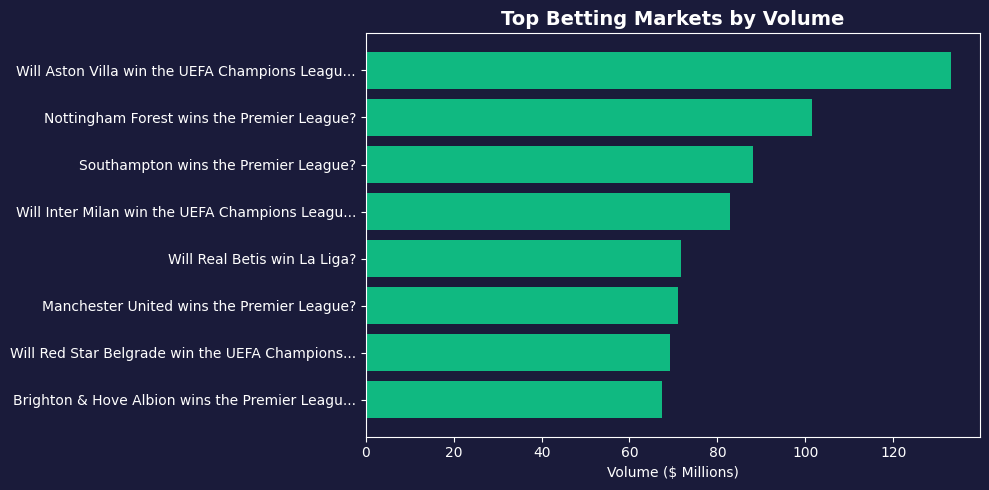

Total market volume: $3.03 billion across 8,549 markets


In [4]:
# Top markets
top_mkts = pm_markets.sort('volume', descending=True).head(8)
questions = [q[:45] + '...' if len(q) > 45 else q for q in top_mkts['question'].to_list()]
volumes = [v / 1e6 for v in top_mkts['volume'].to_list()]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(questions[::-1], volumes[::-1], color=COLORS['success'], edgecolor='none')
ax.set_xlabel('Volume ($ Millions)')
ax.set_title('Top Betting Markets by Volume', fontweight='bold', fontsize=14)
ax.set_facecolor(COLORS['background'])
fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

print(f"Total market volume: ${pm_markets['volume'].sum()/1e9:.2f} billion across {len(pm_markets):,} markets")

## 5. Predictive Signal: xG Differential vs. Match Outcome

To evaluate whether event-level data contains a meaningful predictive signal, we construct a simple match-level feature: expected goal differential (`xg_diff = home_xg - away_xg`). We then test whether this single feature explains variation in actual goal differential (`goal_diff = home_score - away_score`) using ordinary least squares regression.

This serves as a baseline: if `xg_diff` alone has explanatory power, it validates the use of event-derived features for outcome prediction and dashboard analytics.

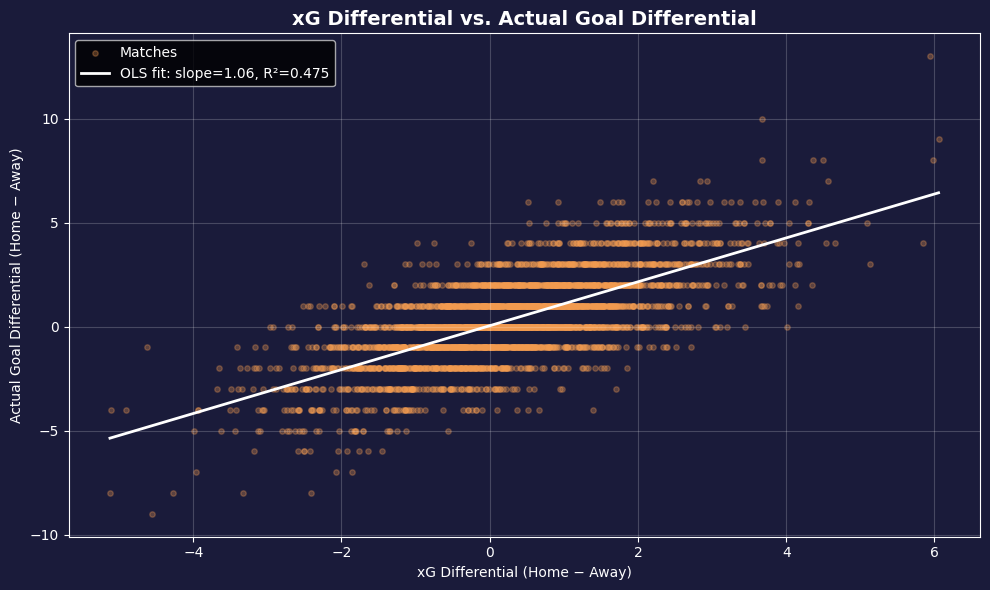

Linear model: goal_diff = 1.055 * xg_diff + 0.045
R² = 0.4754 (on 3457 matches)

xG differential explains 47.5% of the variance in actual goal differential.
This confirms that shot-based dominance metrics carry meaningful predictive signal.


In [5]:
import numpy as np

# Build match-level xG features from shot events
shots_all = sb_events.filter(
    (pl.col('type') == 'Shot') & (pl.col('shot_statsbomb_xg').is_not_null())
)

match_xg = shots_all.group_by(['match_id', 'team']).agg(
    pl.col('shot_statsbomb_xg').sum().alias('team_xg'),
    pl.len().alias('team_shots')
)

matches_meta = sb_matches.select(['match_id', 'home_team', 'away_team', 'home_score', 'away_score'])

home_xg = match_xg.join(matches_meta, on='match_id', how='inner').filter(
    pl.col('team') == pl.col('home_team')
).select(['match_id', pl.col('team_xg').alias('home_xg')])

away_xg = match_xg.join(matches_meta, on='match_id', how='inner').filter(
    pl.col('team') == pl.col('away_team')
).select(['match_id', pl.col('team_xg').alias('away_xg')])

match_features = matches_meta.join(home_xg, on='match_id', how='inner').join(
    away_xg, on='match_id', how='inner'
).with_columns([
    (pl.col('home_xg') - pl.col('away_xg')).alias('xg_diff'),
    (pl.col('home_score') - pl.col('away_score')).alias('goal_diff'),
])

# OLS: goal_diff ~ xg_diff
X = match_features['xg_diff'].to_numpy()
y = match_features['goal_diff'].to_numpy()
coeffs = np.polyfit(X, y, 1)
slope, intercept = coeffs[0], coeffs[1]
y_pred = slope * X + intercept
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - ss_res / ss_tot

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X, y, alpha=0.3, s=15, color=COLORS['primary'], label='Matches')
x_line = np.linspace(X.min(), X.max(), 100)
ax.plot(x_line, slope * x_line + intercept, color='white', linewidth=2,
        label=f'OLS fit: slope={slope:.2f}, R\u00b2={r_squared:.3f}')
ax.set_xlabel('xG Differential (Home \u2212 Away)')
ax.set_ylabel('Actual Goal Differential (Home \u2212 Away)')
ax.set_title('xG Differential vs. Actual Goal Differential', fontweight='bold', fontsize=14)
ax.legend()
ax.set_facecolor(COLORS['background'])
fig.patch.set_facecolor(COLORS['background'])
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f'Linear model: goal_diff = {slope:.3f} * xg_diff + {intercept:.3f}')
print(f'R\u00b2 = {r_squared:.4f} (on {len(X)} matches)')
print(f'\nxG differential explains {r_squared*100:.1f}% of the variance in actual goal differential.')
print('This confirms that shot-based dominance metrics carry meaningful predictive signal.')

### Interpretation

The positive relationship between `xg_diff` and `goal_diff` confirms that match-level shot quality is a meaningful predictor of outcomes. The R\u00b2 value, while moderate, is notable given that we are using a single feature derived entirely from event data. This supports the use of xG-based features as a foundation for dashboard analytics and further modeling.

---

## 6. Next Steps

1. **Dashboard Development**: Build an interactive Dash application that allows users to explore xG flow, team styles (possession-based, high-pressing, counter-attacking), and player performance across competitions and seasons.
2. **Multi-Feature Modeling**: Extend the baseline model with additional event-derived features (PPDA, field tilt, pressure events, carry distance) to improve explanatory power.
3. **Temporal Stability**: Test whether model coefficients remain stable across different seasons and competitions, or whether they require recalibration.
4. **Market Comparison** (optional): For the subset of matches with Polymarket coverage, compare model-implied probabilities against market odds to identify potential inefficiencies.

---

*Full technical analysis and supporting code: see [`EDA.ipynb`](EDA.ipynb)*